# Project outline/plan

1. Prepare the building dataset
    - Need rough estimates of the total value of the property/building
        - can do this with a simple linear relationship 
2. Plot government owned land and create selection unit dataset
    - Use hexagons as selection shapes 
    - remove selection units that overlap with a property (don't want to burn a property we're trying to save)
    - Need rough estimates of the cost to have prescribed burn for each selection unit
        - use traveltime proxy, average cost per acre burned, resources needed, landcover type
    - In this dataset, I will need to find a way to measure how much property damage will be avoided by selecting each unit
        - Will use the building dataset and euclidean distance (start by assuming any buildings within x radius will be 100% avoided property damage)
3. Start selecting units
    - carry out procedure similar to lab 3 where I have a fixed budget and want to maximize the property damage avoided.
    

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio import open as r_open
from rasterio.plot import show as r_show 
import requests

def wf(x):
    return '/Users/dannyskahill/Documents/DS 508/project/' + x

## Importing Datasets

In [2]:
ca = gpd.read_file(wf('ca-state-boundary/CA_State_TIGER2016.shp'))
cap = gpd.read_file(wf('ca-places-boundaries/CA_Places_TIGER2016.shp'))
fb = gpd.read_file(wf('S_USA.AdministrativeForest/S_USA.AdministrativeForest.shp'))
#thr = gpd.read_file(wf('fthrt14_2.gdb'))
fire = gpd.read_file("https://opendata.arcgis.com/datasets/31219c833eb54598ba83d09fa0adb346_1.geojson")

In [3]:
fire = fire.to_crs('EPSG:3857')

In [4]:
fb = fb.to_crs('EPSG:3857')

In [5]:
extent = [ca.bounds['minx'][0], ca.bounds['maxx'][0], ca.bounds['miny'][0], ca.bounds['maxy'][0]]

## Visualizing datasets

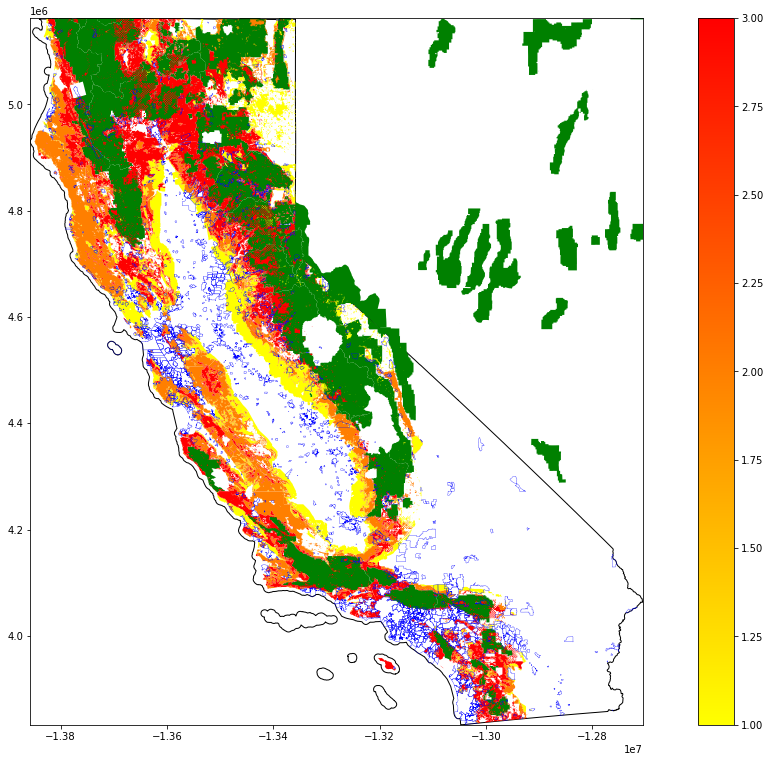

In [66]:
fig, ax = plt.subplots()
ca.plot(color='None', edgecolor='black', ax=ax)
fb.plot(color='green', ax=ax)
fire.plot('HAZ_CODE', cmap='autumn_r', ax=ax, legend=True)
cap.plot(color='None', edgecolor='blue', ax=ax, linewidth=.3)
ax.set_xlim([extent[0],  extent[1]])
ax.set_ylim([extent[2], extent[3]])
fig.set_size_inches(20, 13)

## Opening and visualizing continuous fire threat level raster

In [6]:
r_file = r_open(wf('RDS-2015-0047-3/Data/whp2020_GeoTIF/whp2020_cnt_conus.tif'))

In [7]:
r_file.crs

CRS.from_wkt('PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

In [8]:
ca1 = ca.to_crs(r_file.crs)

In [9]:
ca_bounds = [ca1.bounds['minx'][0], ca1.bounds['maxx'][0], ca1.bounds['miny'][0], ca1.bounds['maxy'][0]]
extent1 = [r_file.bounds[i] for i in [0,2,1,3]]

In [10]:
r = r_file.read(1)

In [11]:
r_file.profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 2147483647.0, 'width': 17132, 'height': 10803, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(270.0, 0.0, -2361825.000000002,
       0.0, -270.0, 3175604.999999998), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [12]:
r = r.astype(float)

In [13]:
r[r == 2147483647.0] = np.nan

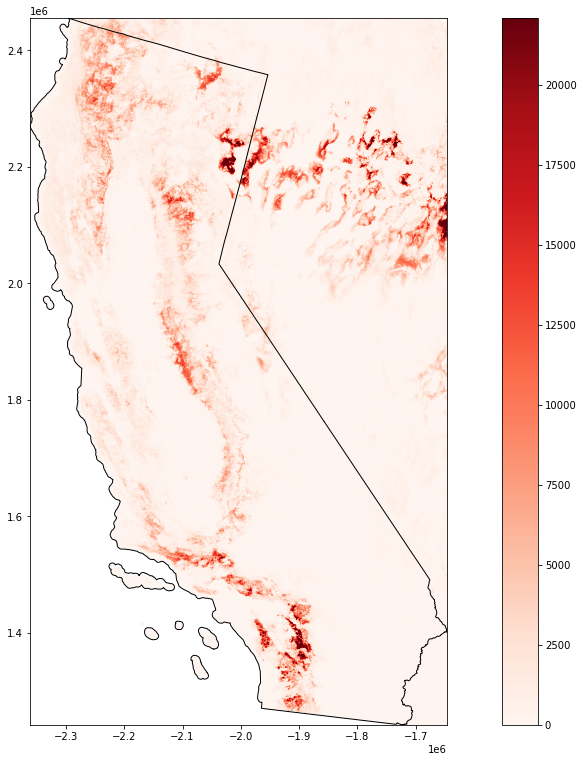

In [166]:
fig, ax = plt.subplots()
ca1.plot(color='None', edgecolor='black', ax=ax)
#fb.plot(color='green', ax=ax)
#fire.plot('HAZ_CODE', cmap='autumn_r', ax=ax, legend=True)
ras = ax.imshow(r, extent=extent1, cmap='Reds', vmin=0, vmax=22081)
#cap.plot(color='None', edgecolor='blue', ax=ax, linewidth=.3)
ax.set_xlim([ca_bounds[0],  ca_bounds[1]])
ax.set_ylim([ca_bounds[2], ca_bounds[3]])
fig.set_size_inches(20, 13)
fig.colorbar(ras, ax=ax)

In [167]:
"""from osgeo import gdal
lc = gdal.Open(wf('nlcd_2019_land_cover_l48_20210604.img'))"""

In [14]:
r_file1 = r_open(wf('calandcover.tif'))

In [15]:
ca2 = ca.to_crs(r_file1.crs)
ca_bounds2 = [ca2.bounds['minx'][0], ca2.bounds['maxx'][0], ca2.bounds['miny'][0], ca2.bounds['maxy'][0]]
extent2 = [r_file1.bounds[i] for i in [0,2,1,3]]
r1 = r_file1.read(1)

In [16]:
r[r == -9999.0] = np.nan

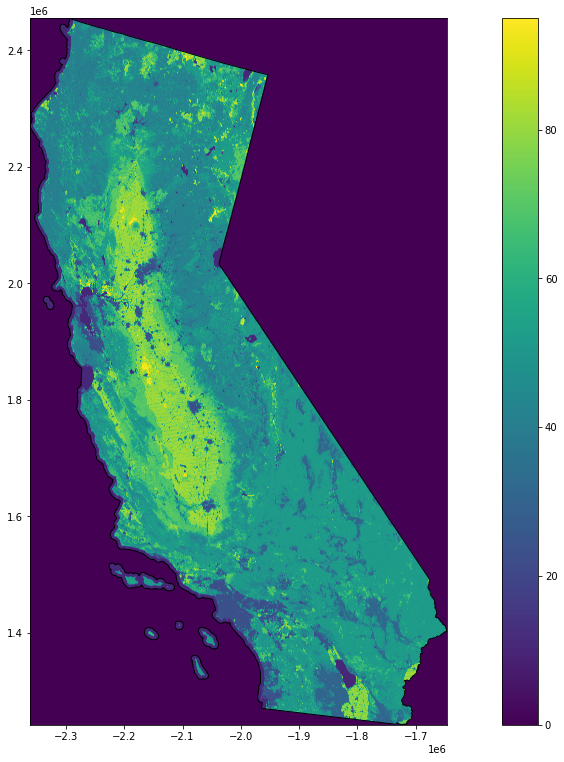

In [669]:
fig, ax = plt.subplots()
ras1 = ax.imshow(r1, extent=extent2)
ca2.plot(color='None', edgecolor='black', ax=ax)
ax.set_xlim([ca_bounds2[0],  ca_bounds2[1]])
ax.set_ylim([ca_bounds2[2], ca_bounds2[3]])
fig.set_size_inches(20, 13)
fig.colorbar(ras1, ax=ax)

## Zillow and Microsoft Footprints

In [17]:
mf = gpd.read_file(wf('California.geojson'))

In [18]:
mf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
ca2 = ca.to_crs('EPSG:4326')

In [20]:
extent2 = [ca2.bounds['minx'][0], ca2.bounds['maxx'][0], ca2.bounds['miny'][0], ca2.bounds['maxy'][0]]

In [21]:
sample = mf.sample(10000)

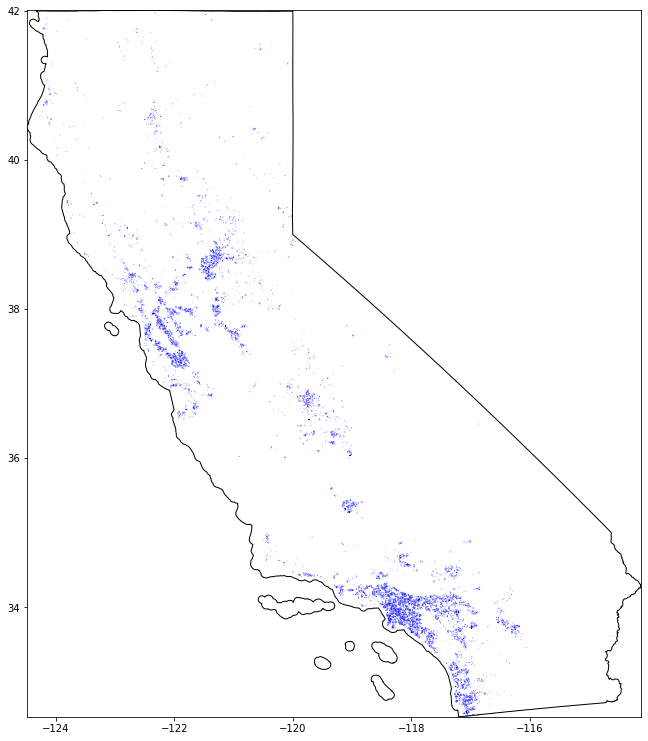

In [45]:
fig, ax = plt.subplots()
sample.plot(color='None', edgecolor='blue', ax=ax)
ca2.plot(color='None', edgecolor='black', ax=ax)
ax.set_xlim([extent2[0],  extent2[1]])
ax.set_ylim([extent2[2], extent2[3]])
fig.set_size_inches(20, 13)

In [22]:
mf = mf[mf['release'] == 2]

In [23]:
mf_s = mf.copy()

In [24]:
mf_s['m2'] = mf_s.to_crs('EPSG:3310').area

In [25]:
mf_s['geometry'] = mf_s['geometry'].simplify(.05)

In [26]:
mf_s

,release,capture_dates_range,geometry,m2
257,2,6/4/2020-6/7/2020,"POLYGON ((-114.49763 33.96796, -114.49750 33.9...",181.176994
258,2,6/4/2020-6/7/2020,"POLYGON ((-114.49833 33.96629, -114.49820 33.9...",458.514802
260,2,6/4/2020-6/7/2020,"POLYGON ((-114.49859 33.96690, -114.49874 33.9...",144.509631
261,2,6/4/2020-6/7/2020,"POLYGON ((-114.50120 33.96786, -114.50120 33.9...",229.753156
268,2,7/5/2015-6/7/2020,"POLYGON ((-114.46939 34.00748, -114.46953 34.0...",115.787226
...,...,...,...,...
11542907,2,5/8/2019-6/21/2019,"POLYGON ((-124.31114 40.58217, -124.31108 40.5...",445.231219
11542908,2,5/8/2019-6/21/2019,"POLYGON ((-124.31944 40.34252, -124.31969 40.3...",458.979099
11542909,2,5/8/2019-6/21/2019,"POLYGON ((-124.32783 40.26998, -124.32795 40.2...",110.209833
11542910,2,5/8/2019-6/21/2019,"POLYGON ((-124.33579 40.46180, -124.33586 40.4...",144.777305


In [27]:
#zillow data for zip codes
zlo = pd.read_csv(wf('median_values_by_zip.csv'))

In [28]:
#shapefile for zip codes
zips = gpd.read_file(wf('/nhgis0001_shape/US_zcta_2019.shp'))

In [29]:
zlo

,fips,zip_id,val_t_za,val_b_za
0,6001,94501,453396.0,312614.0
1,6001,94502,579868.0,392780.0
2,6001,94536,483482.0,336311.0
3,6001,94538,405344.0,275972.0
4,6001,94539,816714.0,542291.0
...,...,...,...,...
1795,6115,95918,27259.0,NaN
1796,6115,95935,177651.0,164203.0
1797,6115,95961,189496.5,161262.0
1798,6115,95962,111596.5,90828.0


In [30]:
zips['GEOID10'] = zips['GEOID10'].astype(int)

In [31]:
zips.columns

Index(['GISJOIN', 'ZCTA5CE10', 'GEOID10', 'CLASSFP10', 'MTFCC10', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')

In [32]:
zips = zips[['GEOID10','Shape_Area','geometry']]

In [33]:
zlo = pd.merge(zlo, zips, left_on='zip_id', right_on='GEOID10', how='inner')

In [34]:
zlo = gpd.GeoDataFrame(zlo)

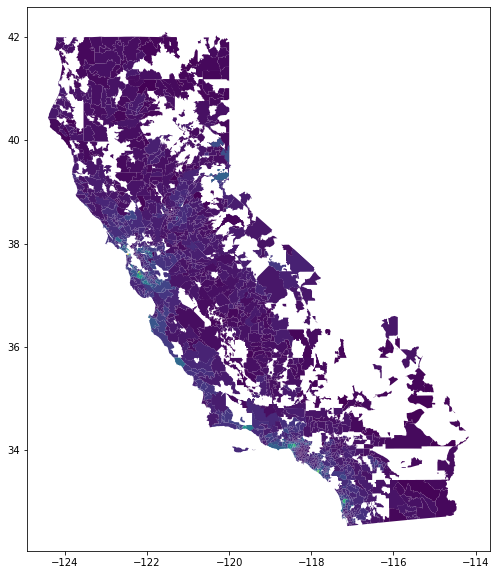

In [300]:
fig, ax = plt.subplots()
zlo.plot(zlo['val_t_za'], cmap='viridis', ax=ax)
fig.set_size_inches(12, 10)


## Country Boundaries 

In [51]:
counties = gpd.read_file('https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson')

<AxesSubplot:>

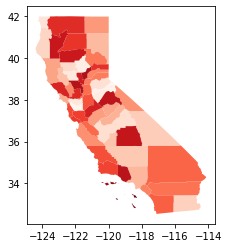

In [55]:
counties.plot(cmap='Reds')

In [ ]:
counties = counties[[]]

In [63]:
t1 = mf_s.sample(100)

In [64]:
t1 = gpd.sjoin(t1, counties, how='inner', op='within')

In [69]:
counties.columns

Index(['OBJECTID', 'COUNTY_NAME', 'COUNTY_ABBREV', 'COUNTY_NUM', 'COUNTY_CODE',
       'COUNTY_FIPS', 'ISLAND', 'GlobalID', 'SHAPE_Length', 'SHAPE_Area',
       'geometry'],
      dtype='object')

## Creating the structures (property damage) dataset
- property damage dataset will have: price estimates, threat level, avg threat level of surrounding area
#### Assigning zipcode to microsoft footprint data

In [35]:
zlo = zlo.to_crs('EPSG:4326')

In [36]:
test = mf_s.sample(2000)

In [37]:
mf_s = gpd.sjoin(mf_s, zlo, how='inner')

In [38]:
mf_s = mf_s.dropna()

In [39]:
mf_z = mf_s.drop_duplicates(subset=['geometry', 'm2'], keep='last')

In [40]:
mf_z.head(2)

,release,capture_dates_range,geometry,m2,index_right,fips,zip_id,val_t_za,val_b_za,GEOID10,Shape_Area
257,2,6/4/2020-6/7/2020,"POLYGON ((-114.49763 33.96796, -114.49750 33.9...",181.176994,1045,6065,92225,109305.0,80855.0,92225,1.561417e+09
258,2,6/4/2020-6/7/2020,"POLYGON ((-114.49833 33.96629, -114.49820 33.9...",458.514802,1045,6065,92225,109305.0,80855.0,92225,1.561417e+09


In [41]:
mf_z['zip_id'].value_counts()

92345    30269
94558    27668
93274    27650
93307    27303
95076    27298
         ...  
89060       11
95306       11
92227        3
92384        2
93271        1
Name: zip_id, Length: 1548, dtype: int64

In [42]:
medians = mf_z.groupby('zip_id').agg({'m2':'median', 'val_t_za': 'median'}).reset_index()

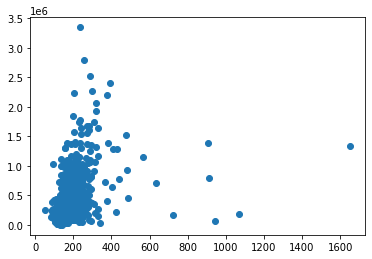

In [301]:
plt.scatter(medians['m2'], medians['val_t_za'])

In [43]:
medians['price_per_meter'] = medians['val_t_za'] / medians['m2']

In [44]:
medians = medians.rename(columns={'m2': 'median_m2'})

In [45]:
medians = medians.drop('val_t_za', 1)

In [46]:
sam = mf_z.sample(2000)

In [47]:
mf_z = pd.merge(mf_z, medians, left_on='zip_id', right_on='zip_id', how='inner')

In [48]:
#price estimates => ((mf[m2] -  median[m2]) * price_per_meter) + median_price
mf_z['estimates'] = ((mf_z['m2'] - mf_z['median_m2']) * mf_z['price_per_meter']) + mf_z['val_t_za']

In [49]:
mf_z = mf_z[~(mf_z['estimates'] <= 0)]

In [50]:
sam = mf_z.sample(30000)

/Users/dannyskahill/miniconda3/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


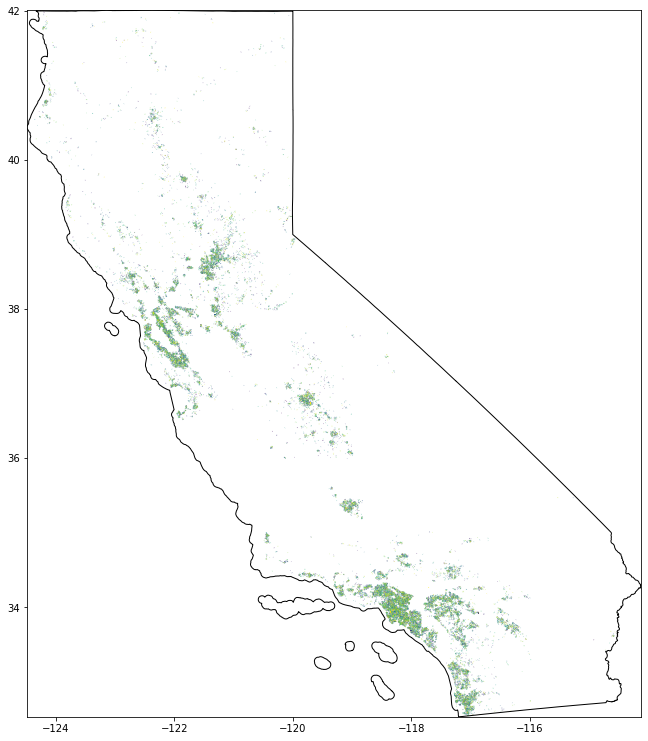

In [384]:
fig, ax = plt.subplots()
sam.plot(sam['estimates'], cmap='viridis', color='None', edgecolor='blue', ax=ax, legend=True)
ca2.plot(color='None', edgecolor='black', ax=ax)
ax.set_xlim([extent2[0],  extent2[1]])
ax.set_ylim([extent2[2], extent2[3]])
fig.set_size_inches(20, 13)

In [51]:
mf_z

,release,capture_dates_range,geometry,m2,index_right,fips,zip_id,val_t_za,val_b_za,GEOID10,Shape_Area,median_m2,price_per_meter,estimates
0,2,6/4/2020-6/7/2020,"POLYGON ((-114.49763 33.96796, -114.49750 33.9...",181.176994,1045,6065,92225,109305.0,80855.0,92225,1.561417e+09,190.623493,573.407812,103888.303857
1,2,6/4/2020-6/7/2020,"POLYGON ((-114.49833 33.96629, -114.49820 33.9...",458.514802,1045,6065,92225,109305.0,80855.0,92225,1.561417e+09,190.623493,573.407812,262915.969575
2,2,6/4/2020-6/7/2020,"POLYGON ((-114.49859 33.96690, -114.49874 33.9...",144.509631,1045,6065,92225,109305.0,80855.0,92225,1.561417e+09,190.623493,573.407812,82862.951163
3,2,6/4/2020-6/7/2020,"POLYGON ((-114.50120 33.96786, -114.50120 33.9...",229.753156,1045,6065,92225,109305.0,80855.0,92225,1.561417e+09,190.623493,573.407812,131742.254624
4,2,7/5/2015-6/7/2020,"POLYGON ((-114.46939 34.00748, -114.46953 34.0...",115.787226,1045,6065,92225,109305.0,80855.0,92225,1.561417e+09,190.623493,573.407812,66393.300081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10503999,2,6/4/2020-6/7/2020,"POLYGON ((-115.02012 32.99082, -115.02007 32.9...",329.729756,313,6025,92227,144000.0,104015.0,92227,1.437808e+09,329.729756,436.721277,144000.000000
10504000,2,9/25/2015-6/7/2020,"POLYGON ((-115.02980 32.98781, -115.02997 32.9...",2112.598515,313,6025,92227,144000.0,104015.0,92227,1.437808e+09,329.729756,436.721277,922616.720119
10504001,2,3/17/2019-3/24/2019,"POLYGON ((-118.99847 36.40758, -118.99841 36.4...",53.937541,1733,6107,93271,248600.0,164430.5,93271,9.918991e+08,53.937541,4609.034704,248600.000000
10504002,2,12/31/2009-5/14/2019,"POLYGON ((-116.18169 35.99540, -116.18170 35.9...",174.517821,331,6027,92384,58621.5,40719.0,92384,3.626599e+08,122.051850,480.299971,83820.904347


In [52]:
mf_z.nlargest(10, 'estimates')

,release,capture_dates_range,geometry,m2,index_right,fips,zip_id,val_t_za,val_b_za,GEOID10,Shape_Area,median_m2,price_per_meter,estimates
8717975,2,4/13/2019-4/23/2019,"POLYGON ((-121.94149 37.49391, -121.93908 37.4...",350251.020812,3,6001,94538,405344.0,275972.0,94538,4.304741e+07,213.243413,1900.851209,6.657751e+08
4467006,2,5/29/2018-2/25/2019,"POLYGON ((-118.35014 33.82944, -118.34910 33.8...",188181.835420,552,6037,90503,456874.0,117776.0,90503,1.374465e+07,193.452181,2361.689578,4.444271e+08
4694001,2,5/29/2018-2/25/2019,"POLYGON ((-118.37945 33.92135, -118.37945 33.9...",120001.711714,520,6037,90245,608108.0,172799.5,90245,1.415324e+07,174.578776,3483.287115,4.180004e+08
2523329,2,1/3/2015-1/17/2015,"POLYGON ((-117.72184 33.65404, -117.71690 33.6...",92315.473636,911,6059,92618,816400.0,346378.0,92618,5.481702e+07,201.405188,4053.520217,3.742026e+08
8398180,2,4/13/2019-4/23/2019,"POLYGON ((-121.89977 37.41722, -121.89888 37.4...",142113.968908,59,6085,95035,525012.0,259738.0,95035,6.068225e+07,210.844665,2490.041664,3.538697e+08
8953262,2,4/13/2019-4/23/2019,"POLYGON ((-122.01228 37.32736, -122.01579 37.3...",69481.324609,1507,6085,95014,924009.0,300746.0,95014,7.058742e+07,245.732444,3760.223866,2.612653e+08
3712253,2,4/13/2018-1/25/2019,"POLYGON ((-118.16372 33.81570, -118.16117 33.8...",81776.554223,584,6037,90807,438000.0,127940.0,90807,1.521787e+07,149.129950,2937.035795,2.401807e+08
8048128,2,4/26/2019-5/1/2019,"POLYGON ((-121.71939 38.68186, -121.72599 38.6...",169398.212851,1793,6113,95776,300657.5,207603.5,95776,2.423688e+08,212.645809,1413.888672,2.395102e+08
7395561,2,6/16/2020-6/19/2020,"POLYGON ((-121.40498 37.74789, -121.40695 37.7...",105147.899561,1399,6077,95304,509803.0,352069.5,95304,4.220173e+08,237.917872,2142.768829,2.253076e+08
3285074,2,4/13/2018-2/8/2019,"POLYGON ((-118.13843 33.82984, -118.14148 33.8...",99219.972283,585,6037,90808,383522.0,120340.5,90808,1.805121e+07,169.525585,2262.325177,2.244678e+08


In [105]:
mf_z.to_file(wf('SAVED/footprints_estimates.shp'))

/Users/dannyskahill/miniconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


## Creating the selection units dataset
- selection units dataset will have: geometry of unit, threat level, cost of selection, num buildings within certain radius, cost of buildings within certain radius, median cost of buildings in the radius, cost/m2 for buildings in radius, total area of buildings in surrounding radius, area of su 

### Transforming the data into equal sized selectin units

In [53]:
#finding the average acreage for each prescribed burns
cbs = gpd.read_file(wf('ds397.gdb'))

In [54]:
cbs = cbs.drop_duplicates(subset=['TREATMENT_ID'], keep='last')

In [55]:
cbs_2020 = cbs[cbs['YEAR_'] == '2020']

In [56]:
cbs.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - California
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [57]:
print(f"the average size of controlled burns in 2020 was {cbs_2020['GIS_ACRES'].mean()} acres")

the average size of controlled burns in 2020 was 124.69499859488324 acres


We will use 100 acres as the size of our selection units. Using square selection units, so 100 will make easier calculations.

In [58]:
#public land ownership (area of land we can have controlled burns on)
pl = gpd.read_file(wf('California_Land_Ownership/California_Land_Ownership.shp'))

In [59]:
pl = pl.to_crs('EPSG:3310')

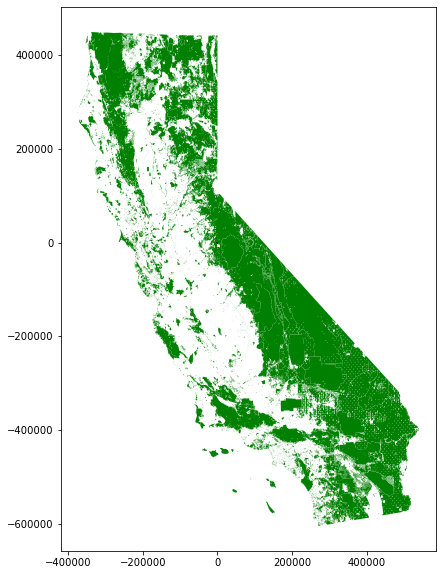

In [60]:
fig, ax = plt.subplots()
pl.plot(color='green', ax=ax)
ca2.plot(color='None', edgecolor='black', ax=ax)
fig.set_size_inches(12, 10)

In [61]:
pl

,OBJECTID,OWN_LEVEL,OWN_AGENCY,OWN_GROUP,RULEID,Shape__Are,Shape__Len,geometry
0,1,City,"Adelanto, City of",Local Government,1,7.224624e+03,337.317626,"POLYGON ((237033.331 -385997.571, 236965.980 -..."
1,2,City,"Adelanto, City of",Local Government,1,3.640787e+03,244.304291,"POLYGON ((237719.556 -379414.468, 237661.876 -..."
2,3,City,"Adelanto, City of",Local Government,1,9.859758e+04,1441.290874,"POLYGON ((237505.813 -379450.739, 237149.188 -..."
3,4,City,"Adelanto, City of",Local Government,1,2.170186e+04,875.594523,"POLYGON ((237745.121 -378947.010, 237750.998 -..."
4,5,City,"Adelanto, City of",Local Government,1,4.799182e+04,856.807251,"POLYGON ((236359.755 -378449.955, 236233.418 -..."
...,...,...,...,...,...,...,...,...
41635,41636,State,University of California,Other State Lands,6,3.904986e+07,50482.167272,"POLYGON ((-110521.467 142891.952, -110531.229 ..."
41636,41637,State,University of California,Other State Lands,6,5.120306e+05,3677.316460,"POLYGON ((-324122.512 147051.140, -324122.514 ..."
41637,41638,State,University of California,Other State Lands,6,2.745785e+05,2096.142232,"POLYGON ((-311630.532 199336.775, -311643.738 ..."
41638,41639,State,University of California,Other State Lands,6,2.785962e+07,51357.879004,"POLYGON ((-308813.264 198798.188, -308829.303 ..."


In [69]:
#the distance from the bounds ==> we will use this to calculate the right selection unit size
from shapely.geometry import Point
import geopandas as gpd

xmin, ymin, xmax, ymax= [-124.45, 32.53, -114.12, 42.01]

pnt1 = Point(xmin, ymin)
pnt2 = Point(xmax, ymin)
points_df = gpd.GeoDataFrame({'geometry': [pnt1, pnt2]}, crs='epsg:4326')
points_df = points_df.to_crs('EPSG:3310')
points_df2 = points_df.shift() #We shift the dataframe by 1 to align pnt1 with pnt2
points_df.distance(points_df2)[1]

971603.91924729

In [70]:
import math 

#100 acres is about 404686 square meters ==> our selection units will be 636m x 636m

print(math.sqrt(404686))

print(f"the number of cells we will need is {(points_df.distance(points_df2)[1]/math.sqrt(404685.64224))}")

636.1493535326433
the number of cells we will need is 1527.3211287917297


In [71]:
from shapely.geometry import Polygon
import shapely

#trying to create grid for selection units
xmin, ymin, xmax, ymax= pl.total_bounds

# how many cells across and down
n_cells=1524
cell_size = (xmax-xmin)/n_cells

# projection of the grid
crs = 'EPSG:3310'

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

It doesn't make sense to plot the grid over the map of california at this stage because the selection units are so small, we would not see any clear outlines.

In [72]:
test = cell.sample(100000)

In [73]:
#merge public land and grid 
merged = gpd.sjoin(cell, pl, how='left', op='within')

In [74]:
merged = merged.dropna()

In [626]:
ca2 = ca2.to_crs('EPSG:3310')

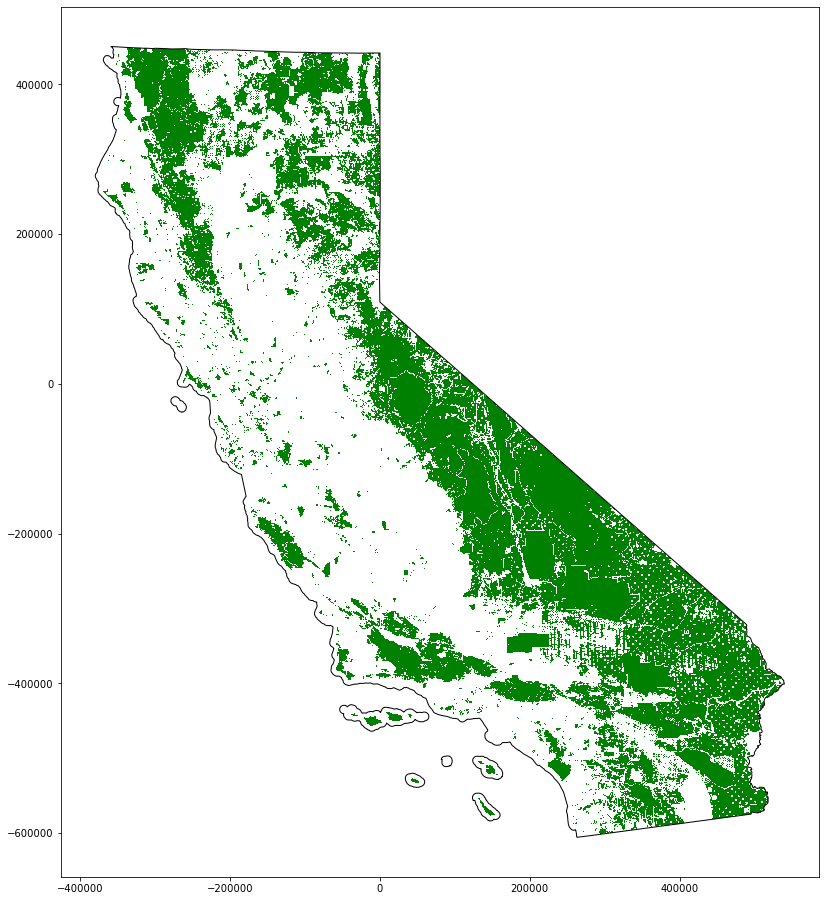

In [616]:
fig, ax = plt.subplots()
merged.plot(color='green', ax=ax)
ca2.plot(color='None', edgecolor='black', ax=ax)
fig.set_size_inches(20, 16)

In [77]:
t2 = merged.dropna().sample(10000)

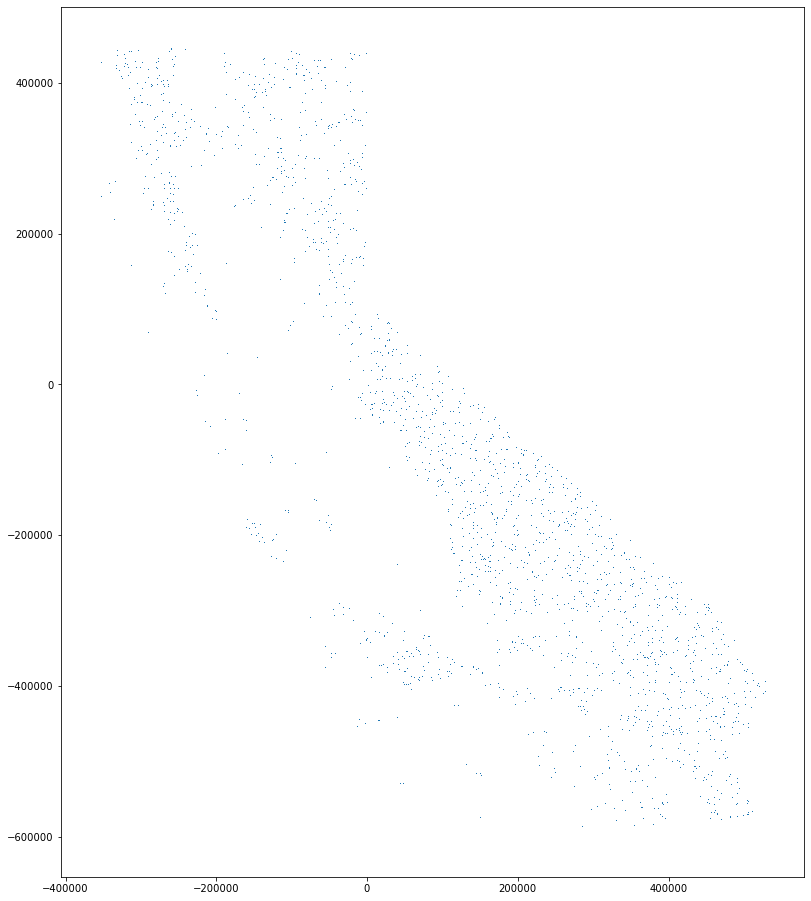

In [78]:
fig, ax = plt.subplots()
t2.plot(ax=ax)
fig.set_size_inches(20, 16)

The plot above proves to us that our data is now in proper selection units and we can now move on to setting up the cost for each unit.

In [562]:
#su = selection units
su = merged.copy()

In [76]:
su.to_file(wf('SAVED/selection_units.shp'))

/Users/dannyskahill/miniconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [460]:
merged.head(1).area

13751    359740.7877
dtype: float64

In [461]:
math.sqrt(359740)

599.7832941988298

### Determining the cost of selecting each selection unit
will be based off of threat level (higher the threat, the more fuel and the more resources we need), traveltime, and landcover type.

In [652]:
#import traveltime raster
r_file2 = r_open(wf('Travel/traveltimeca.tif'))

In [653]:
ca3 = ca.to_crs(r_file2.crs)

In [654]:
ca_bounds3 = [ca3.bounds['minx'][0], ca3.bounds['maxx'][0], ca3.bounds['miny'][0], ca3.bounds['maxy'][0]]
extent1 = [r_file2.bounds[i] for i in [0,2,1,3]]

In [655]:
r2 = r_file2.read(1)

In [656]:
r2 = r2.astype(float)
r2[r2 == -9999.0] = np.nan

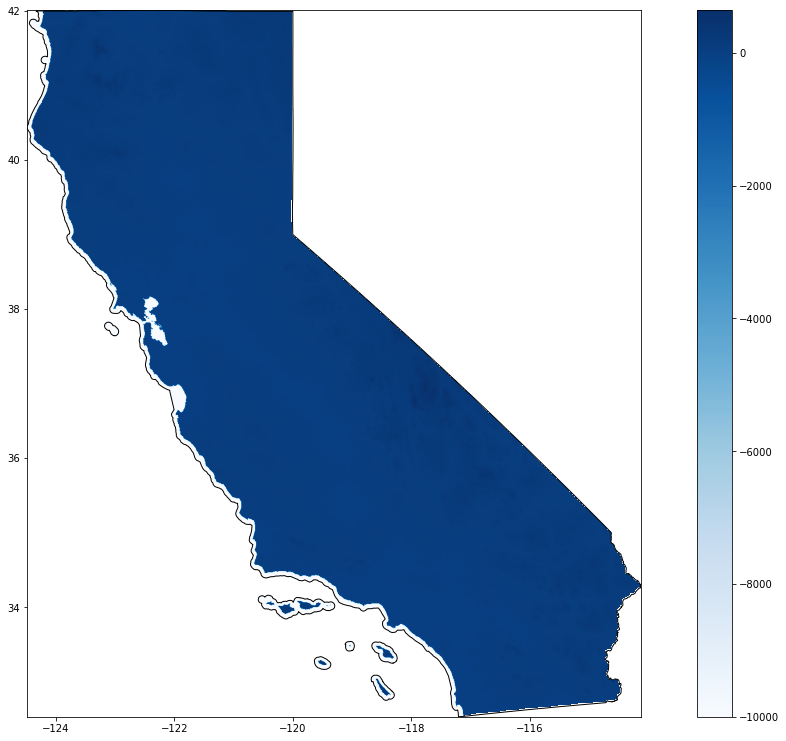

In [677]:
fig, ax = plt.subplots()
ras2 = ax.imshow(r2, extent=extent1, cmap='Blues')
ca3.plot(color='None', edgecolor='black', ax=ax)
ax.set_xlim([ca_bounds3[0], ca_bounds3[1]])
ax.set_ylim([ca_bounds3[2], ca_bounds3[3]])
fig.set_size_inches(20, 13)
fig.colorbar(ras2, ax=ax)

In [106]:
#import zonal stats dfs [threat level, traveltime, landcover type]
ttzs = pd.read_csv(wf('SAVED/traveltimezs.csv'))
lctzs = pd.read_csv(wf('SAVED/landcovertypezs.csv'))
tlzs = pd.read_csv(wf('SAVED/firethreatsuzs.csv'))


In [563]:
su = su.reset_index()

In [564]:
su['traveltime'] = ttzs['mean']
su['landcover'] = lctzs['median']
su['threat_level'] = tlzs['mean']

### Filtering out irrelevant selection units 
(units that intersect with buildings, threat level = 0, landcover = developed land, )

In [565]:
su = su[su['threat_level'] > 0]

In [566]:
su = su[~(su['landcover'] == 21)] 
su = su[~(su['landcover'] == 22)] 
su = su[~(su['landcover'] == 23)] 
su = su[~(su['landcover'] == 24)] 

In [567]:
su = su[~(su['landcover'] == 95)]
su = su[~(su['landcover'] == 90)] 
su = su[~(su['landcover'] == 11)] 
su = su[~(su['landcover'] == 82)]

In [ ]:
mf_z = mf_z.drop(columns=['index_right'])

In [485]:
"""inter = su.copy()
inter = inter.to_crs('EPSG:4326')"""


In [281]:
sample = mf_z.sample(100000)

In [489]:
su = su.drop('index_right', axis=1)
su = su.rename(columns={'index':'indx'})

In [491]:
inter = su.copy()

In [ ]:
no_b = gpd.sjoin(inter, mf_z_crs, how='left', op='contains')


In [ ]:
no_b = no_b[no_b['median_m2'].isna()]
no_b.columns

In [287]:
no_b = no_b.drop(columns=['index_right', 'release',
       'capture_dates_range', 'm2', 'fips', 'zip_id', 'val_t_za', 'val_b_za',
       'GEOID10', 'Shape_Area', 'median_m2', 'price_per_meter', 'estimates'])

In [568]:
su = no_b.copy()
su.head()

,indx,geometry,OBJECTID,OWN_LEVEL,OWN_AGENCY,OWN_GROUP,RULEID,Shape__Are,Shape__Len,traveltime,landcover,threat_level,centroid,boundary
0,13751,"POLYGON ((-124.35667 40.26176, -124.35699 40.2...",22685.0,Federal,Bureau of Land Management,Bureau of Land Management,10.0,4.259204e+08,299574.706134,194.5,52.0,153.363636,POINT (-370090.485 258345.411),"POLYGON ((-367890.485 258345.411, -367901.079 ..."
1,13752,"POLYGON ((-124.35699 40.26715, -124.35732 40.2...",22685.0,Federal,Bureau of Land Management,Bureau of Land Management,10.0,4.259204e+08,299574.706134,194.0,52.0,70.416667,POINT (-370090.485 258945.195),"POLYGON ((-367890.485 258945.195, -367901.079 ..."
2,13753,"POLYGON ((-124.35732 40.27255, -124.35764 40.2...",22685.0,Federal,Bureau of Land Management,Bureau of Land Management,10.0,4.259204e+08,299574.706134,194.0,43.0,107.363636,POINT (-370090.485 259544.979),"POLYGON ((-367890.485 259544.979, -367901.079 ..."
3,13754,"POLYGON ((-124.35764 40.27794, -124.35796 40.2...",22685.0,Federal,Bureau of Land Management,Bureau of Land Management,10.0,4.259204e+08,299574.706134,191.5,52.0,86.700000,POINT (-370090.485 260144.763),"POLYGON ((-367890.485 260144.763, -367901.079 ..."
4,13755,"POLYGON ((-124.35796 40.28334, -124.35829 40.2...",22685.0,Federal,Bureau of Land Management,Bureau of Land Management,10.0,4.259204e+08,299574.706134,190.0,52.0,89.250000,POINT (-370090.485 260744.547),"POLYGON ((-367890.485 260744.547, -367901.079 ..."


In [355]:
intersecting = gpd.sjoin(mf_z_crs, su, op='within')

In [361]:
inters = intersecting['indx'].unique()

In [569]:
su = su[~(su['indx'].isin(inters))]

### Find the buildings within a mile radius of each selection unit 

In [570]:
su = su.to_crs('EPSG:3310')

In [571]:
from shapely.geometry import Polygon, LineString, Point
#find centroids and create boundaries 
su['centroid'] = su.centroid
su['boundary'] = su['centroid'].buffer(8600)

In [497]:
(f"the boundary will encapsulate anything that is at most {math.sqrt(su['boundary'].head(1).area/3.14159265358979) - 600}m outside of the selection unit")

'the boundary will encapsulate anything that is at most 7993.093116504348m outside of the selection unit'

In [305]:
#sample = mf_z.sample(100000)

In [318]:
#sample = sample.to_crs('EPSG:3310')

In [330]:
#mf_z_crs = mf_z.to_crs('EPSG:3310')

In [368]:
su = su.set_geometry('boundary')

In [377]:
#try sjoin
affected = gpd.sjoin(mf_z_crs, su, op='within')


In [370]:
one_mile #= affected.copy()
one_mile.shape

(222881, 27)

In [374]:
two_miles #= affected.copy()
two_miles.shape

(1847507, 27)

In [378]:
five_miles #= affected.copy()
five_miles.shape

(26681317, 27)

In [354]:
su = su.set_geometry('geometry')

In [379]:
two_miles['indx'].value_counts()

1634408    4237
1947530    4073
727558     3958
1843547    3769
1841788    3657
           ... 
361940        1
1857893       1
1439233       1
1358835       1
1364041       1
Name: indx, Length: 35609, dtype: int64

In [380]:
five_miles['indx'].value_counts()

1560522    28825
1560523    27651
1569328    26882
1571087    25984
1558764    25340
           ...  
896815         1
273950         1
487030         1
896814         1
409800         1
Name: indx, Length: 100999, dtype: int64

In [381]:
one_mile['indx'].value_counts()

1787420    1344
727558      960
727554      955
1875287     877
579763      802
           ... 
1081155       1
383136        1
1050572       1
2082868       1
1314818       1
Name: indx, Length: 12982, dtype: int64

In [399]:
b = gpd.GeoSeries(one_mile['geometry_left'])
a = gpd.GeoSeries(one_mile['geometry_right'])

one_mile['distances'] = b.distance(a)

In [403]:
b = gpd.GeoSeries(two_miles['geometry_left'])
a = gpd.GeoSeries(two_miles['geometry_right'])
two_miles['distances'] = b.distance(a)

In [404]:
b = gpd.GeoSeries(five_miles['geometry_left'])
a = gpd.GeoSeries(five_miles['geometry_right'])
five_miles['distances'] = b.distance(a)

In [423]:
#these are the 3 different assumption levels for protection (1, 2, 5 miles)
om_agg = one_mile.groupby('indx').agg(avoided_cost=('estimates', 'sum'),
                            avg_avoided_cost=('estimates', 'mean'),
                            avoided_m2=('m2', 'sum'),
                            avg_avoided_m2=('m2', 'mean'),
                            avg_price_m2=('price_per_meter', 'mean'),
                            num_avoided=('GEOID10', 'count'),
                            total_distance=('distances', 'sum'),
                            avg_distance=('distances', 'mean'))
                        
tm_agg = two_miles.groupby('indx').agg(avoided_cost=('estimates', 'sum'),
                            avg_avoided_cost=('estimates', 'mean'),
                            avoided_m2=('m2', 'sum'),
                            avg_avoided_m2=('m2', 'mean'),
                            avg_price_m2=('price_per_meter', 'mean'),
                            num_avoided=('GEOID10', 'count'),
                            total_distance=('distances', 'sum'),
                            avg_distance=('distances', 'mean'))
                        
fm_agg = five_miles.groupby('indx').agg(avoided_cost=('estimates', 'sum'),
                            avg_avoided_cost=('estimates', 'mean'),
                            avoided_m2=('m2', 'sum'),
                            avg_avoided_m2=('m2', 'mean'),
                            avg_price_m2=('price_per_meter', 'mean'),
                            num_avoided=('GEOID10', 'count'),
                            total_distance=('distances', 'sum'),
                            avg_distance=('distances', 'mean'))

## Determining Cost of Selection Unit

In [572]:
#cleanup
su = su[['indx', 'geometry', 'OWN_LEVEL', 'OWN_AGENCY', 'traveltime', 'landcover',
       'threat_level', 'centroid', 'boundary']] 

In [573]:
su = su.to_crs('EPSG:3310')
su = su.set_geometry('geometry')
su.head(1).area

0    359740.787699
dtype: float64

In [575]:
su['acres'] = su.area*0.000247105

In [576]:
#cost for landcover type
lc_costs = {81: 45, 71:45, 52:45, 43:254, 42:125, 31:45}

In [577]:
def cost(x, lc_costs):
    if x in lc_costs:
        return lc_costs[x]
    else:
        return 75

In [578]:
#cost for traveltime (adding as constant)
mn = su['traveltime'].mean()
std = su['traveltime'].std()
su['traveltime'] = su['traveltime'].apply(lambda x: (x-mn)/std)

In [579]:
su['traveltime'] = su['traveltime'] * su['acres']

In [582]:
#cost for threatlevel (adding as constant)
tlmn = su['threat_level'].mean()
tlstd = su['threat_level'].std()
su['threat_level'] = su['threat_level'].apply(lambda x: (x-tlmn)/tlstd)
su['threat_level'] = su['threat_level'] * su['acres']

In [580]:
#total cost for su
su['landcover'] = su['landcover'].round(0)
su['su_cost'] = su['landcover'].apply(lambda x: cost(x, lc_costs)*su['acres'].iloc[1])

In [584]:
su['su_cost'] = su['su_cost'] + su['threat_level'] + su['traveltime']

In [596]:
su = su[~(su['su_cost'] < 100)]

In [597]:
su

,indx,geometry,OWN_LEVEL,OWN_AGENCY,traveltime,landcover,threat_level,centroid,boundary,acres,su_cost
0,13751,"POLYGON ((-370390.377 258045.519, -370390.377 ...",Federal,Bureau of Land Management,47.037642,52.0,-38.627637,POINT (-370090.485 258345.411),"POLYGON ((-361490.485 258345.411, -361531.896 ...",88.893747,4008.628635
1,13752,"POLYGON ((-370390.377 258645.303, -370390.377 ...",Federal,Bureau of Land Management,46.641566,52.0,-41.040938,POINT (-370090.485 258945.195),"POLYGON ((-361490.485 258945.195, -361531.896 ...",88.893747,4005.819258
2,13753,"POLYGON ((-370390.377 259245.087, -370390.377 ...",Federal,Bureau of Land Management,46.641566,43.0,-39.965985,POINT (-370090.485 259544.979),"POLYGON ((-361490.485 259544.979, -361531.896 ...",88.893747,22585.687407
3,13754,"POLYGON ((-370390.377 259844.871, -370390.377 ...",Federal,Bureau of Land Management,44.661185,52.0,-40.567183,POINT (-370090.485 260144.763),"POLYGON ((-361490.485 260144.763, -361531.896 ...",88.893747,4004.312633
4,13755,"POLYGON ((-370390.377 260444.655, -370390.377 ...",Federal,Bureau of Land Management,43.472956,52.0,-40.492992,POINT (-370090.485 260744.547),"POLYGON ((-361490.485 260744.547, -361531.896 ...",88.893747,4003.198595
...,...,...,...,...,...,...,...,...,...,...,...
486878,2675786,"POLYGON ((537682.525 -396318.771, 537682.525 -...",Federal,Bureau of Land Management,-3.660107,52.0,-41.904737,POINT (537982.417 -396018.879),"POLYGON ((546582.417 -396018.879, 546541.005 -...",88.893747,3954.653787
486879,2677538,"POLYGON ((538282.308 -400517.259, 538282.308 -...",Federal,Bureau of Land Management,-8.545046,52.0,-41.748684,POINT (538582.200 -400217.367),"POLYGON ((547182.200 -400217.367, 547140.789 -...",88.893747,3949.924900
486880,2677539,"POLYGON ((538282.308 -399917.475, 538282.308 -...",Federal,Bureau of Land Management,-7.224792,52.0,-41.418359,POINT (538582.200 -399617.583),"POLYGON ((547182.200 -399617.583, 547140.789 -...",88.893747,3951.575479
486881,2677540,"POLYGON ((538282.308 -399317.691, 538282.308 -...",Federal,Bureau of Land Management,-6.828716,52.0,-41.644650,POINT (538582.200 -399017.799),"POLYGON ((547182.200 -399017.799, 547140.789 -...",88.893747,3951.745265


## Merge SU and Boundary Aggs to create final dataset

In [701]:
om = su.copy()
tm = su.copy()
fm = su.copy()

In [702]:
om = om.merge(om_agg, how='inner', left_on='indx', right_on=om_agg.index)

In [703]:
tm = tm.merge(tm_agg, how='inner', left_on='indx', right_on=tm_agg.index)

In [704]:
fm = fm.merge(fm_agg, how='inner', left_on='indx', right_on=fm_agg.index)

In [705]:
om = om.drop('boundary', axis=1)
om = om.drop('centroid', axis=1)
tm = tm.drop('boundary', axis=1)
tm = tm.drop('centroid', axis=1)
fm = fm.drop('boundary', axis=1)
fm = fm.drop('centroid', axis=1)

In [706]:
#save the official datasets 
om.to_file(wf('SAVED/FinalShapefiles/1_mile_radius_selection_units.shp'))
tm.to_file(wf('SAVED/FinalShapefiles/2_mile_radius_selection_units.shp'))
fm.to_file(wf('SAVED/FinalShapefiles/5_mile_radius_selection_units.shp'))

/Users/dannyskahill/miniconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  
/Users/dannyskahill/miniconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dannyskahill/miniconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  after removing the cwd from sys.path.


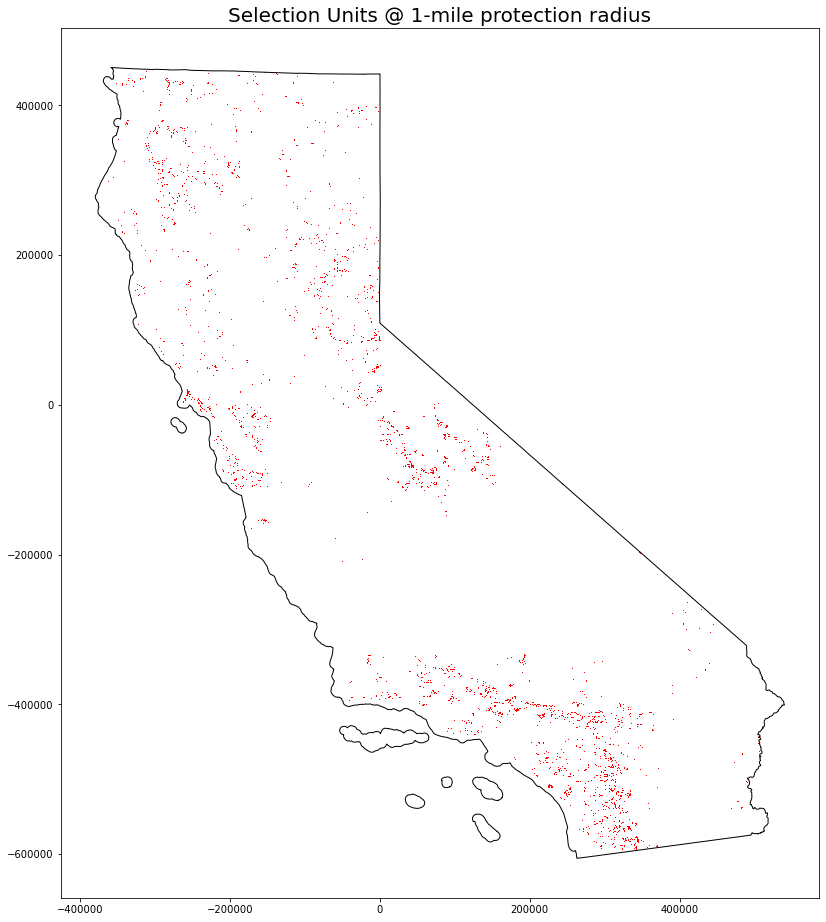

In [627]:
fig, ax = plt.subplots()
om.plot(ax=ax, color='red')
ca2.plot(color='None', edgecolor='black', ax=ax)
plt.title('Selection Units @ 1-mile protection radius',fontsize=20)
fig.set_size_inches(20, 16)

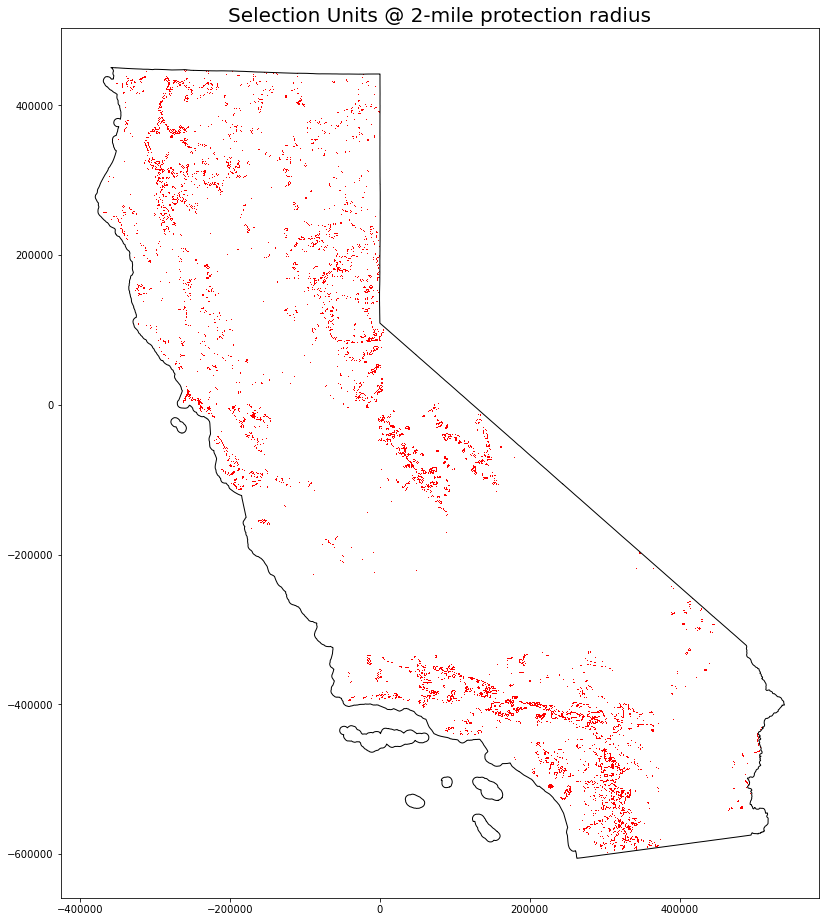

In [630]:
fig, ax = plt.subplots()
tm.plot(ax=ax, color='red')
ca2.plot(color='None', edgecolor='black', ax=ax)
plt.title('Selection Units @ 2-mile protection radius',fontsize=20)
fig.set_size_inches(20, 16)

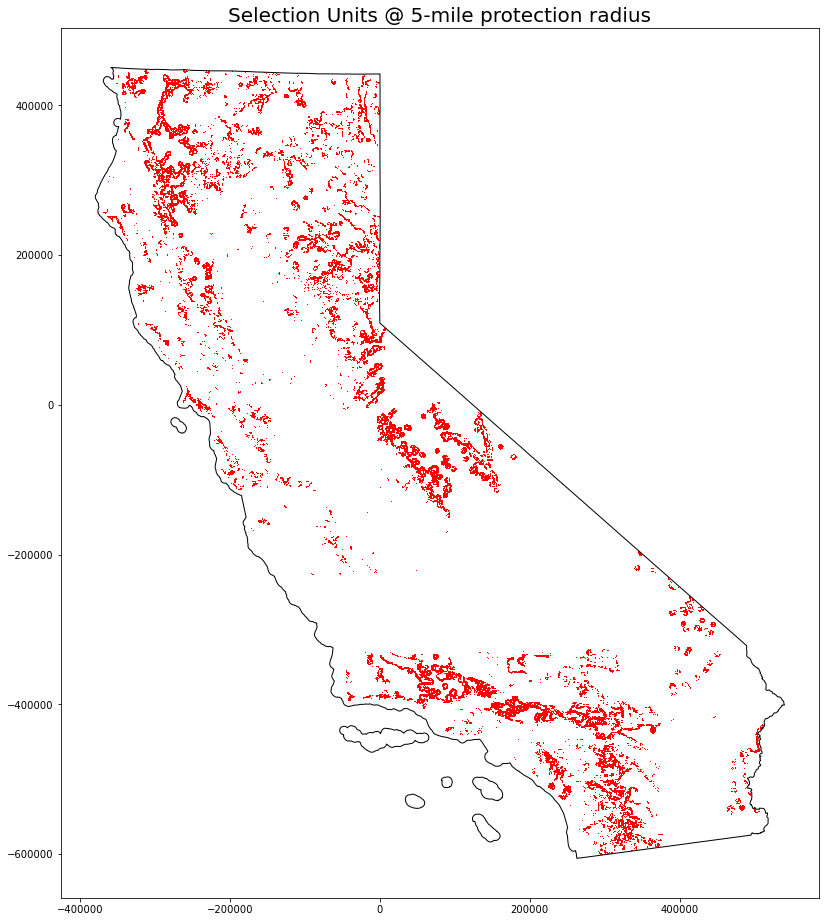

In [631]:
fig, ax = plt.subplots()
fm.plot(ax=ax, color='red')
ca2.plot(color='None', edgecolor='black', ax=ax)
plt.title('Selection Units @ 5-mile protection radius',fontsize=20)
fig.set_size_inches(20, 16)

###### Todo
su:
- remove su that overlap with properties    x
- find traveltime for each su               x
- find landcover type for each su           x
- calculate su cost from landcover and tt   x
- find threat level for each su==> filter out areas where the threat is 0   x
- find the raidus we want to define safe properties from su's               x

We will have to make the assumption that if an area is burned, any property within a 1 mile radius can be affected (i.e. 100% of the properties within the 1 mile radius will be saved)

to create boundaries:
1. find the centroid of each planning unit                 x
2. create new boundary geometry from the point centroid    x
3. use sjoin to find the units within a given boundary--> groupby selection unit and then compute agg stats    x


In [707]:
om

,indx,geometry,OWN_LEVEL,OWN_AGENCY,traveltime,landcover,threat_level,acres,su_cost,avoided_cost,avg_avoided_cost,avoided_m2,avg_avoided_m2,avg_price_m2,num_avoided,total_distance,avg_distance
0,13755,"POLYGON ((-370390.377 260444.655, -370390.377 ...",Federal,Bureau of Land Management,43.472956,52.0,-40.492992,88.893747,4003.198595,1.722593e+05,86129.651156,313.777699,156.888850,548.985166,2,2631.487777,1315.743889
1,15512,"POLYGON ((-369790.593 259245.087, -369790.593 ...",Federal,Bureau of Land Management,45.849413,43.0,-40.636040,88.893747,22584.225199,9.823816e+04,49119.081284,178.945022,89.472511,548.985166,2,2128.654766,1064.327383
2,22548,"POLYGON ((-367391.457 259245.087, -367391.457 ...",Federal,Bureau of Indian Affairs,39.512195,42.0,-33.849261,88.893747,11117.381352,4.080588e+04,40805.877498,74.329654,74.329654,548.985166,1,1060.955663,1060.955663
3,26125,"POLYGON ((-366191.889 294632.340, -366191.889 ...",Non Profit,The Wildlands Conservancy,34.759281,81.0,-42.148073,88.893747,3992.829839,8.390015e+05,419500.768406,708.390654,354.195327,1184.376913,2,1024.132188,512.066094
4,27822,"POLYGON ((-365592.105 257445.735, -365592.105 ...",Federal,Bureau of Land Management,38.323966,42.0,-36.879322,88.893747,11113.163063,1.914930e+05,191493.035850,348.812769,348.812769,548.985166,1,1046.977914,1046.977914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12972,2585968,"POLYGON ((507093.543 -461695.222, 507093.543 -...",Federal,Bureau of Land Management,-30.791324,52.0,-41.639427,88.893747,3927.787879,7.766730e+04,77667.299080,135.448624,135.448624,573.407812,1,1368.149441,1368.149441
12973,2585976,"POLYGON ((507093.543 -456896.950, 507093.543 -...",Federal,Bureau of Indian Affairs,-30.197210,52.0,-42.278263,88.893747,3927.743157,6.732620e+06,137400.417053,11741.417347,239.620762,573.407812,49,42952.201621,876.575543
12974,2587734,"POLYGON ((507693.327 -457496.734, 507693.327 -...",Federal,Bureau of Indian Affairs,-29.801134,52.0,-42.468994,88.893747,3927.948503,1.807484e+05,90374.179447,315.217817,157.608909,573.407812,2,1010.138666,505.069333
12975,2593057,"POLYGON ((509492.679 -429906.672, 509492.679 -...",Federal,Bureau of Indian Affairs,-11.383592,52.0,-40.914862,88.893747,3947.920176,1.074466e+07,188502.735755,18738.244763,328.741136,573.407812,57,53081.166792,931.248540
